In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


In [2]:
#gen1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv',index_col='DATE_TIME'),parse_dates=['DATE_TIME'])
gen1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
sen1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

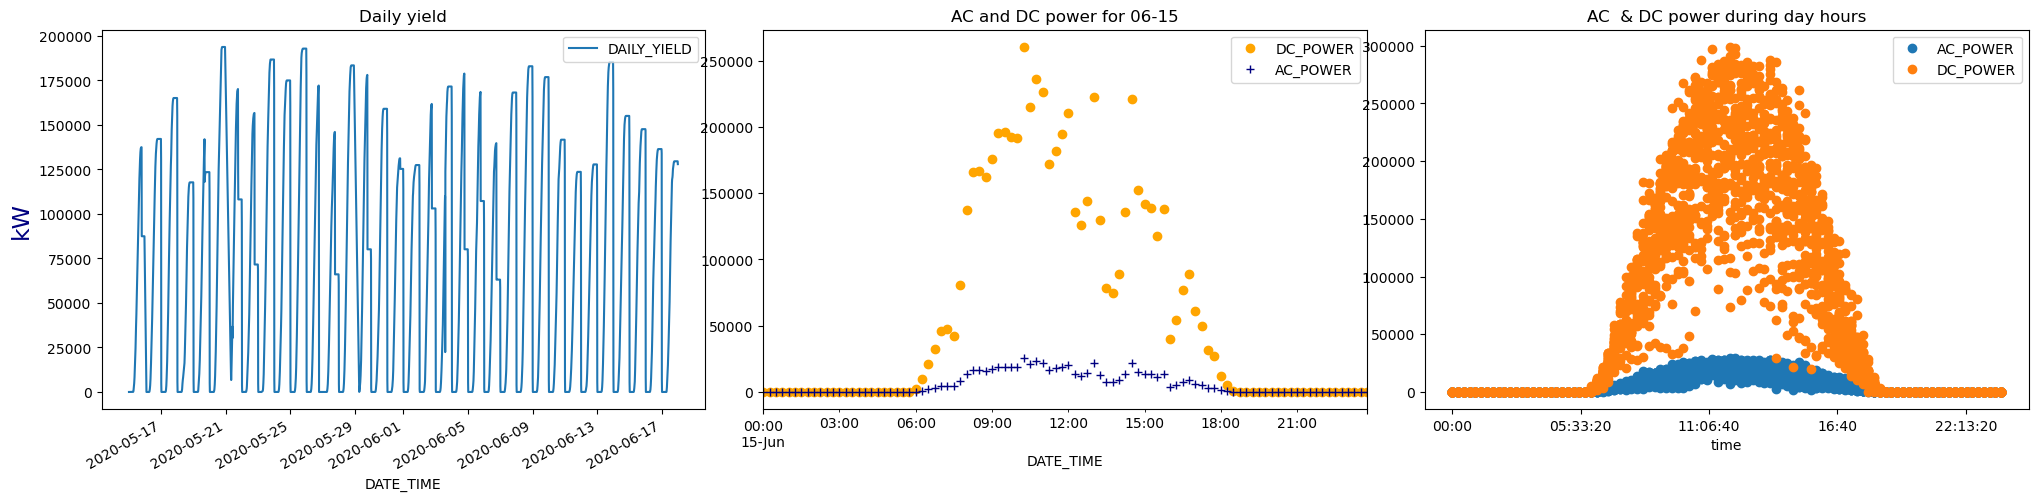

In [3]:
gen1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
gen1.DATE_TIME=pd.to_datetime(gen1.DATE_TIME,format='%d-%m-%Y %H:%M')
gen11=gen1.groupby('DATE_TIME').sum().reset_index()

f,ax=plt.subplots(1,3,dpi=100,figsize=(20,5))
plt.tight_layout()
gen11.plot(x='DATE_TIME',y='DAILY_YIELD',ax=ax[0])
gen11[(gen11.DATE_TIME.dt.day==15) &(gen11.DATE_TIME.dt.month==6)].plot(x='DATE_TIME',y='DC_POWER',color='orange',style='o',ax=ax[1])
gen11[(gen11.DATE_TIME.dt.day==15) &(gen11.DATE_TIME.dt.month==6)].plot(x='DATE_TIME',y='AC_POWER',color='navy',style='+',ax=ax[1])

import datetime as dt 
gen11['time']=gen11.DATE_TIME.dt.time
gen11.set_index('time')[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[2])

ax[0].set_title('Daily yield',)
ax[1].set_title('AC and DC power for 06-15')
ax[2].set_title('AC  & DC power during day hours')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

### Reading DATE_TIME as INDEX or as a COLUMN
Reading the datetime as index while reading csv, may cause some issues in the exported datetime index (see gen1b and the corresponding plots of day and month below). To avoid these issues, two strategies can be chosen:

1. Defining the datetime format as reading csv and assigning datetime to index by useing 'date_parser' (see gen1a below)

    avaialble functions: resample(), slicing based on index, df.index.day (or .year, etc)
2. Reading csv files without datetime index and in the next step define formating of datetime column (see gen1c below)

    available functions: .dt

Text(0.5, 1.0, 'gen1c month')

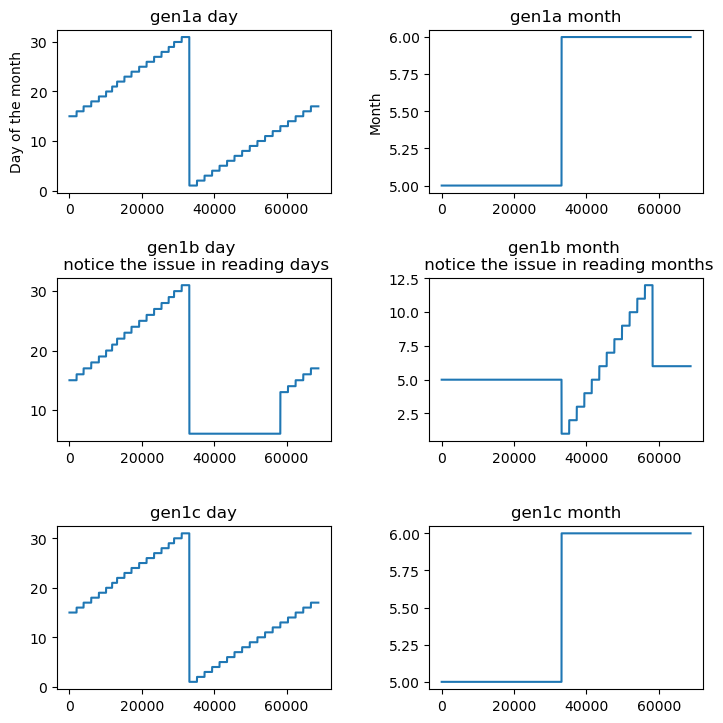

In [4]:
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M') #  "%Y-%d-%m %H:%M")
gen1a=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'], date_parser=custom_date_parser)

gen1b=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'])

gen1c=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
gen1c.DATE_TIME=pd.to_datetime(gen1c.DATE_TIME,format='%d-%m-%Y %H:%M')


import matplotlib.pyplot as plt 
f,ax=plt.subplots(3,2, figsize=(8,8))
plt.tight_layout(pad=4)

ax[0,0].plot(gen1a.index.day) #- gen1a.index.day)
ax[0,0].set_title('gen1a day')
ax[0,0].set_ylabel('Day of the month')


ax[1,0].plot(gen1b.index.day) #- gen1a.index.day)
ax[1,0].set_title('gen1b day \n notice the issue in reading days')

ax[0,1].plot(gen1a.index.month) #- gen1a.index.day)
ax[0,1].set_title('gen1a month')
ax[0,1].set_ylabel('Month')


ax[1,1].plot(gen1b.index.month) #- gen1a.index.day)
ax[1,1].set_title('gen1b month \n notice the issue in reading months')

ax[2,0].plot(gen1c.DATE_TIME.dt.day) #- gen1a.index.day)
ax[2,0].set_title('gen1c day')

ax[2,1].plot(gen1c.DATE_TIME.dt.month) #- gen1a.index.day)
ax[2,1].set_title('gen1c month')


### We proceed with the first stratey


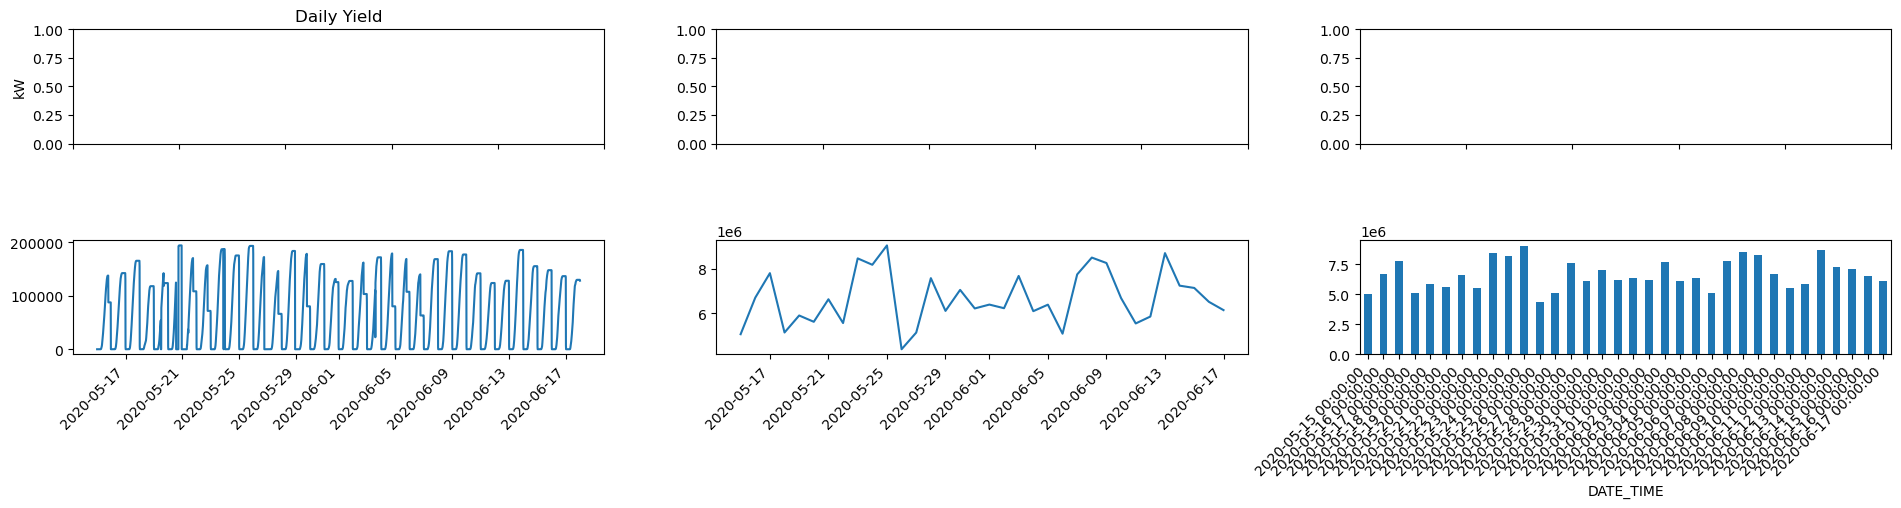

In [5]:
gen1=gen1a.resample('15min').sum() # same as : gen1a.groupby('DATE_TIME').sum()
gen1['time']=gen1.index.time

f,ax=plt.subplots(2,3, figsize=(20,5))
plt.tight_layout(pad=5)
ax[1,0].plot(gen1.DAILY_YIELD)
ax[1,1].plot(gen1.resample('D').sum().DAILY_YIELD)
gen1.resample('D').sum().DAILY_YIELD.plot(kind='bar', ax=ax[1,2])

#sns.scatterplot(data=gen1, x='time',y=gen1.DC_POWER*0.001 ,color='orange', ax=ax[0])
#gen1.plot(x='time',y='AC_POWER', style='*',color='green',ax=ax[1])
#gen1.plot(x='time',y='DC_POWER', style='*',color='orange', ax=ax[1])

#ax[2].plot(gen1.index.strftime('%H:%M'),gen1.AC_POWER*0.001,'o',color='green')
#ax[2].plot(gen1.index.strftime('%H:%M'),gen1.DC_POWER*0.001,'o',color='orange')

ax[0,0].set_title('Daily Yield')
ax[0,0].set_ylabel('kW')
f.autofmt_xdate(rotation=45)


In [6]:
gen1.index.time

array([datetime.time(0, 0), datetime.time(0, 15), datetime.time(0, 30),
       ..., datetime.time(23, 15), datetime.time(23, 30),
       datetime.time(23, 45)], dtype=object)

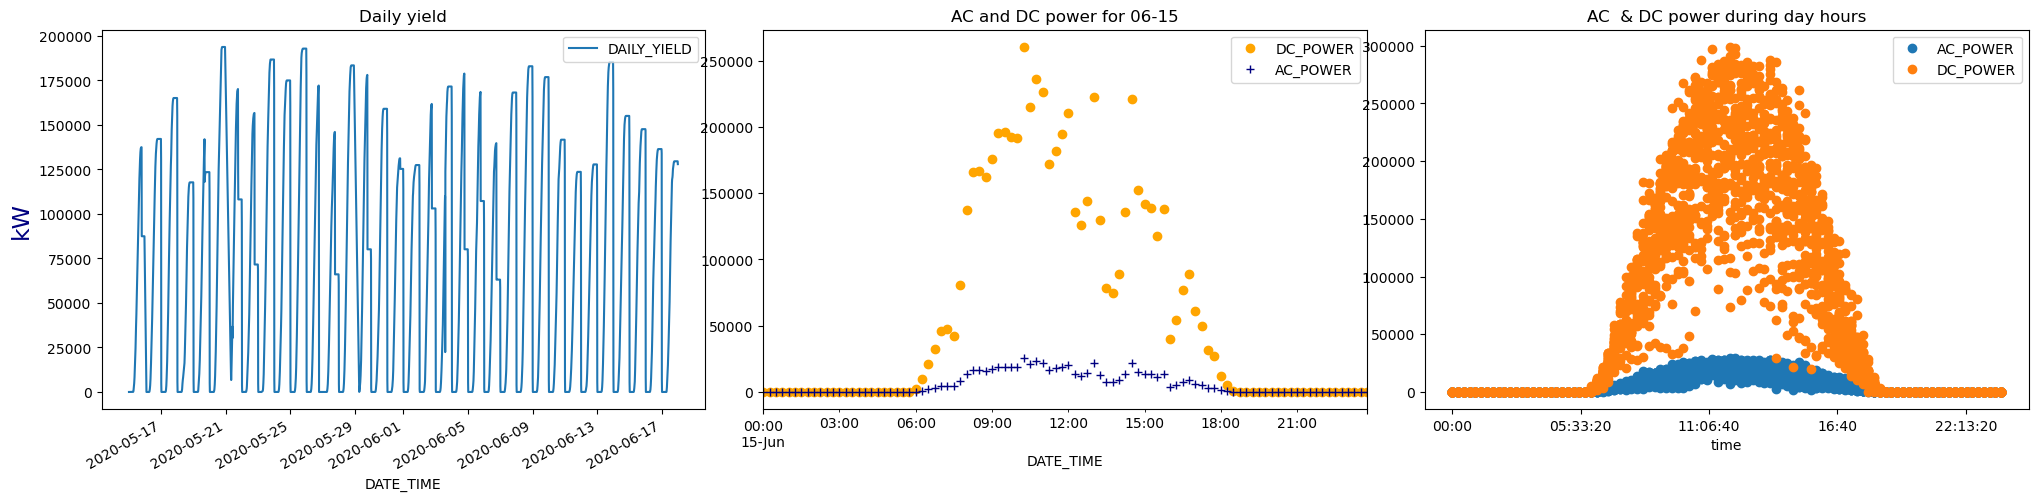

In [7]:
gen1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
gen1.DATE_TIME=pd.to_datetime(gen1.DATE_TIME,format='%d-%m-%Y %H:%M')
gen11=gen1.groupby('DATE_TIME').sum().reset_index()

f,ax=plt.subplots(1,3,dpi=100,figsize=(20,5))
plt.tight_layout()
gen11.plot(x='DATE_TIME',y='DAILY_YIELD',ax=ax[0])
gen11[(gen11.DATE_TIME.dt.day==15) &(gen11.DATE_TIME.dt.month==6)].plot(x='DATE_TIME',y='DC_POWER',color='orange',style='o',ax=ax[1])
gen11[(gen11.DATE_TIME.dt.day==15) &(gen11.DATE_TIME.dt.month==6)].plot(x='DATE_TIME',y='AC_POWER',color='navy',style='+',ax=ax[1])

import datetime as dt 
gen11['time']=gen11.DATE_TIME.dt.time
gen11.set_index('time')[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[2])

ax[0].set_title('Daily yield',)
ax[1].set_title('AC and DC power for 06-15')
ax[2].set_title('AC  & DC power during day hours')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

In [8]:
gen1a.resample('15min').sum()  # same as : gen1a.groupby('DATE_TIME').sum()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-05-15 00:00:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:15:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:30:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:45:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 01:00:00,90970022,0.0,0.0,0.000000,150761642.0
...,...,...,...,...,...
2020-06-17 22:45:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:00:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:15:00,90970022,0.0,0.0,129571.000000,156142755.0
